<a href="https://colab.research.google.com/github/reysilvaa/machine-learning/blob/main/week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Praktikum 1

RNN untuk Analisis Sentimen

## Setup
Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [ ]:

import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()


In [ ]:

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [ ]:

dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [ ]:

for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [ ]:

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Oh my gosh i live in Kentucky and when Mellisa Joan hart came to Louisville she went right through my neighborhood and waved at me i am filthy rich so she wanted to look at my neighborhood oh and i Love being rich any ways she came for the Derby back to my interest in the show...... that show makes you want to point your finger at something and make it disappear i mean it is just so creative and i love it i would love to be on that show....... that show is just amazing i mean who ever came up with that show i want to just give them a big kiss i mean it makes me feel better when I'm sick and makes me happy when I'm mad i mean if someone tells me they don't like it i will talk some sense in to you OK OK"
 b"The film concerns a classic theme. In fact it concerns the theme exploited by Batman, from beginning to end, but in real data and details. The mayor of New York, appreciated and very diligent and dynamic, in order to get some project through slightly faster than normal, yie

## Buat Teks Encoder
Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [ ]:

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [ ]:

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [ ]:

encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[452,  56,   1, ...,   0,   0,   0],
       [  2,  20,   1, ...,   1,   1,   1],
       [  8,  34, 564, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

-Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

-Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [ ]:

for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Oh my gosh i live in Kentucky and when Mellisa Joan hart came to Louisville she went right through my neighborhood and waved at me i am filthy rich so she wanted to look at my neighborhood oh and i Love being rich any ways she came for the Derby back to my interest in the show...... that show makes you want to point your finger at something and make it disappear i mean it is just so creative and i love it i would love to be on that show....... that show is just amazing i mean who ever came up with that show i want to just give them a big kiss i mean it makes me feel better when I'm sick and makes me happy when I'm mad i mean if someone tells me they don't like it i will talk some sense in to you OK OK"
Round-trip:  oh my [UNK] i live in [UNK] and when [UNK] [UNK] [UNK] came to [UNK] she went right through my [UNK] and [UNK] at me i am [UNK] [UNK] so she wanted to look at my [UNK] oh and i love being [UNK] any ways she came for the [UNK] back to my interest in the show that

## Buat Model

In [ ]:

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [ ]:
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True]


In [ ]:
for i, layer in enumerate(model.layers):
    print(f"Lapisan {i}: {layer}")

Lapisan 0: <TextVectorization name=text_vectorization, built=True>
Lapisan 1: <Embedding name=embedding, built=False>
Lapisan 2: <Bidirectional name=bidirectional, built=False>
Lapisan 3: <Dense name=dense, built=False>
Lapisan 4: <Dense name=dense_1, built=False>


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [ ]:

# Contoh teks untuk prediksi
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Ubah teks menjadi array numpy dengan tipe objek (tanpa padding)
sample_array = np.array([sample_text], dtype=object)

# Prediksi menggunakan model
predictions = model.predict(sample_array)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[-1.7113518e-05]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding], dtype=object))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
[-1.7113984e-05]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Contoh teks untuk prediksi
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Ubah teks menjadi array numpy dengan tipe objek (tanpa padding)
sample_array = np.array([sample_text], dtype=object)

# Prediksi menggunakan model
predictions = model.predict(sample_array)
print(predictions[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
[-1.7113518e-05]


In [ ]:

# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding], dtype=object))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
[-1.7113984e-05]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


## Train Model

In [ ]:

history = model.fit(train_dataset, epochs=10,
          validation_data=test_dataset,
          validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - accuracy: 0.5170 - loss: 0.6775 - val_accuracy: 0.7870 - val_loss: 0.4324
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.8115 - loss: 0.4070 - val_accuracy: 0.8547 - val_loss: 0.3307
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8474 - loss: 0.3440 - val_accuracy: 0.8432 - val_loss: 0.3312
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.8566 - loss: 0.3276 - val_accuracy: 0.8474 - val_loss: 0.3402
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.8541 - loss: 0.3282 - val_accuracy: 0.8401 - val_loss: 0.3310
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8558 - loss: 0.3212 - val_accuracy: 0.8578 - val_loss: 0.3285
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8641 - loss: 0.3095 - val_accuracy: 0.8568 - val_loss: 0.3081
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.8687 - loss: 0.3045 - 

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8374 - loss: 0.3333
Test Loss: 0.33427757024765015
Test Accuracy: 0.8360400199890137


(0.0, 0.6393915966153145)

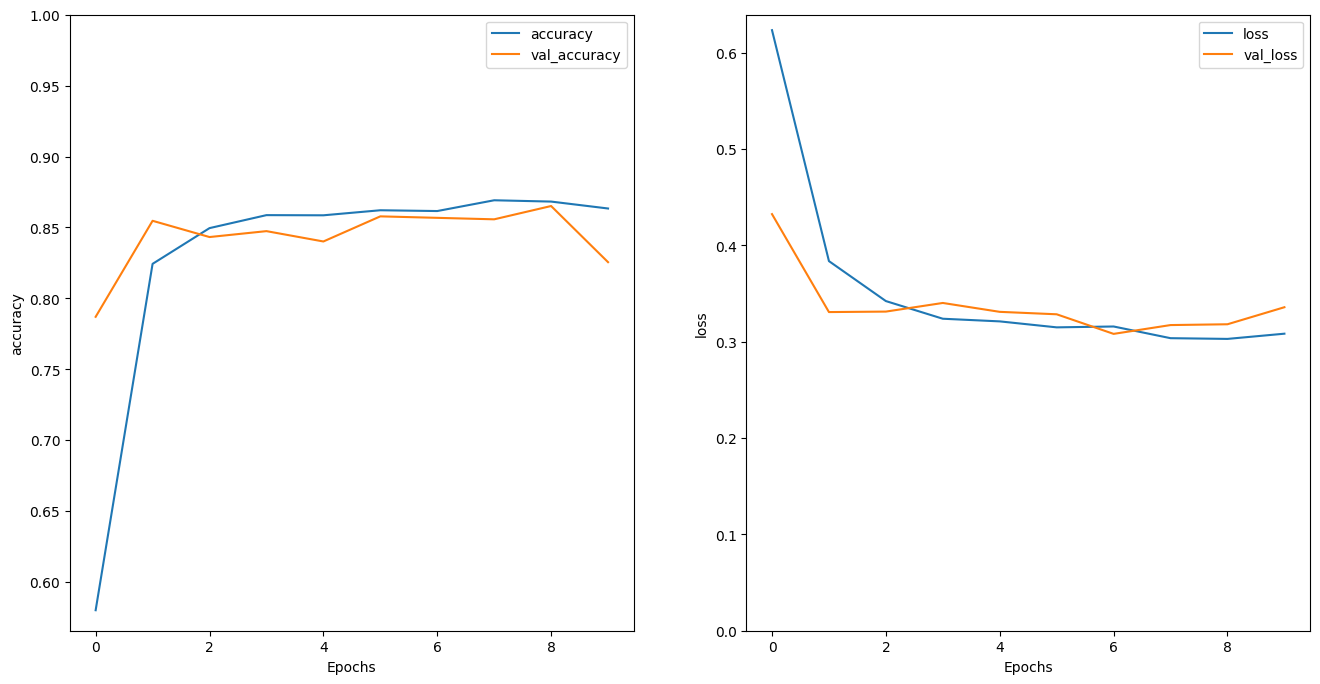

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [ ]:

sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text],dtype=object))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


## Stack two or more LSTM layers

In [ ]:

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer=tf.keras.optimizers.Adam(1e-4),
metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
validation_data=test_dataset,
validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - accuracy: 0.5172 - loss: 0.6790 - val_accuracy: 0.8172 - val_loss: 0.4253
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - accuracy: 0.8172 - loss: 0.4047 - val_accuracy: 0.8547 - val_loss: 0.3321
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 102ms/step - accuracy: 0.8490 - loss: 0.3442 - val_accuracy: 0.8573 - val_loss: 0.3119
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 100ms/step - accuracy: 0.8582 - loss: 0.3237 - val_accuracy: 0.8469 - val_loss: 0.3410
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - accuracy: 0.8610 - loss: 0.3195 - val_accuracy: 0.8620 - val_loss: 0.3196
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.8651 - loss: 0.3186 - val_accuracy: 0.8542 - val_loss: 0.3338
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.8675 - loss: 0.3101 - val_accuracy: 0.8682 - val_loss: 0.3075
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.8725 - loss: 0

In [ ]:

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8576 - loss: 0.3529
Test Loss: 0.35147824883461
Test Accuracy: 0.8569200038909912


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text], dtype=object))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
[[-1.9911888]]


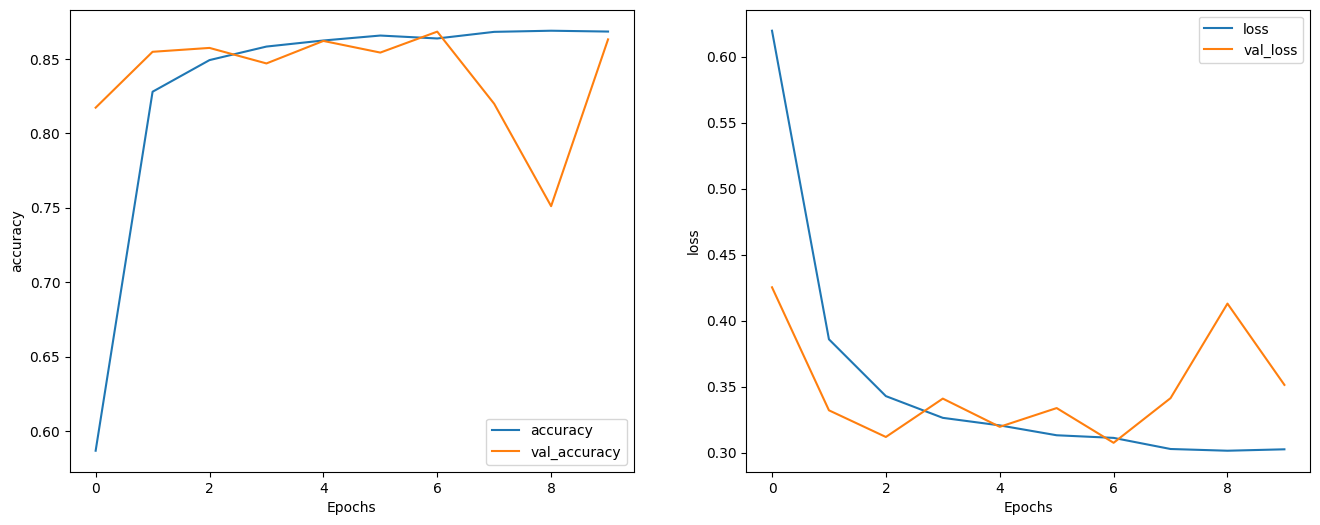

In [ ]:

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')


## Praktikum 2

## Setup
Import TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

## Download Dataset Shakespeare
Sesuaikan dengan lokasi data yang Anda punya.

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')


1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


## Load Data

In [ ]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print(f'Length of text: {len(text)} characters')
print(text[:250])


Length of text: 1115394 characters
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## Olah Teks
Vectorize Teks
Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. tf.keras.layers.StringLookup dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

sekarang buat tf.keras.layers.StringLookup layer:

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

perintah diatas mengconvert token menjadi id

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Karena tujuan tutorial ini adalah untuk menghasilkan teks, penting juga untuk membalikkan representasi ini. Untuk ini Anda dapat menggunakan kode tf.keras.layers.StringLookup(..., invert=True).

Catatan: pada kode ini, daripada meneruskan kosakata asli yang dihasilkan dengan diurutkan(set(teks)) gunakan metode get_vocabulary() dari tf.keras.layers.StringLookup sehingga token [UNK] disetel dengan cara yang sama.

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Lapisan ini mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter tf.RaggedTensor:

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Anda dapat menggunakan tf.strings.reduce_join untuk menggabungkan kembali karakter menjadi string.

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

## Prediksi

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [ ]:
seq_length = 100

# Buat batch urutan dari ids_dataset
sequences = ids_dataset.batch(seq_length + 1, drop_remainder=True)

# Cetak batch urutan pertama
for seq in sequences.take(1):
    print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string:

In [ ]:

for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())


b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
sequences = ids_dataset.batch(seq_length + 1, drop_remainder=True)
dataset = sequences.map(split_input_target)


In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example,target_example in dataset.take(1):
  print("Input :",text_from_ids(input_example).numpy())
  print("Target:",text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


## Membuat Batch Training

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Buat Model

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = self.embedding(inputs, training=training)
        if states is None:
            # Menggunakan status awal default jika tidak diberikan
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x


In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__()  # Memanggil konstruktor kelas induk tanpa argumen tambahan
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.gru(x)
        return self.dense(x)


In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## Uji Model

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (64, 100, 256)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (64, 100, 1024)             │       3,938,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (64, 100, 66)               │          67,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,022,850 (15.35 MB)

 Trainable params: 4,022,850 (15.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([27, 28, 32, 12, 15, 52, 49,  0, 61, 47, 58, 15, 36, 50, 19, 31, 44,
       46, 22, 59, 44,  2, 41, 65, 55,  6, 54, 38, 18,  4, 62, 36, 60, 33,
       21, 28,  8,  6,  2, 44, 38, 19, 54, 46, 45, 10, 12, 11, 25, 24, 38,
       48, 17, 31, 45, 26, 57, 55,  9, 19, 47, 12,  1,  7, 57, 25, 26, 37,
       15,  9, 50, 29, 20, 34, 18, 63, 24, 41, 25, 48, 60, 44, 20, 33, 36,
       46,  4, 40, 22, 10, 41, 25, 33, 60, 59, 12, 57, 47, 53, 63])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"lk. There's other of our friends\nWill greet us here anon, my gentle Varrius.\n\nISABELLA:\nTo speak so "

Next Char Predictions:
 b"NOS;Bmj[UNK]vhsBWkFRegIte bzp'oYE$wWuTHO-' eYFogf3;:LKYiDRfMrp.Fh;\n,rLMXB.kPGUExKbLiueGTWg$aI3bLTut;rhnx"


## Train Model

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1897807, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.008316

In [ ]:
model.compile(optimizer='adam',loss=loss)

## Konfigurasi Checkpoints

In [ ]:
import os

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files with .weights.h5 suffix
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)


## Lakukan Proses Training

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 897s 5s/step - loss: 3.0281
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 952s 5s/step - loss: 1.9036
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 911s 5s/step - loss: 1.6224
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 917s 5s/step - loss: 1.4733
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 924s 5s/step - loss: 1.3874
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 895s 5s/step - loss: 1.3291
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 917s 5s/step - loss: 1.2776
Epoch 8/20
148/172 ━━━━━━━━━━━━━━━━━━━━ 2:06 5s/step - loss: 1.2298

## Generate Teks

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs):
    # Convert strings to token IDs
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model without states
    predicted_logits = self.model(inputs=input_ids)  # Hilangkan states dari sini

    # Only use the last prediction
    predicted_logits = predicted_logits[:, -1, :] / self.temperature

    # Apply the prediction mask
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    return predicted_chars


In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
    next_char = one_step_model.generate_one_step(next_char)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)


ROMEO:

BRD.
Yor h st sellimbest htelofunort o sschin meeder whenow, houphncourenored wo wire f d me f in;
Yor mand men:
IO: heng, ale recut t s, agherd bl.
Dill weren, drabyowas e ors ioocowin t,
IETRD womuenecoulllow, l no f coraingonth uselllyonet hthe wathesirch tr m ut he y! mbrtoret sess mereyocht mpinganon:
Y r t t I pr omyors, penonD d VORit,
Toreelive theanencotherathusesst h,

TIO:
CAUSTom a IUxer G erdee twe, he y lld alll ayowh Cast tond s! ard a wowat:
Lomo, tof 'd as myonthanerereradlit akey, INThous t s brexily qu you aminomellaco, ff IENCovesers,
Why uidamy, hind d fo ifunowid ior-leabe, one,
Juty:
Cou der. baseagoph yorou,

JUS3 ngh, t I d.
Tean:
IAn novellon bouseso hon
Ande twe that bet! anisellllfoouk?
The?
We.
G ckind cilit theves ts bowhal't ilally thichat gat,
Bulllecoullor rthee br e dove cout ROLORA:
A:
Azeaskeprour boo; t utos:
ISe ant sthyoverd our:

Tere mascof ag is wareremy t y, pyor t,

CAMy tind urt y y t, w ifrshenomous cililat,
Ax' ur f omeseais wee, m

In [ ]:
start = time.time()
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char = one_step_model.generate_one_step(next_char)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nAnou conondraposstheleme ng suceso'stht ee athedy, mas, leap t foo ar m s:\n\n\nIO: wit, teeeererito deat t at lindarest ne f dister.\nVORI:\nK:\nD han y y on bu trease ire!\nHEMETESel damoore?\nHINGRARNTEShy chiverouthesere s relonorank:\nCHERD pop s t, m ure mermese at imathanor the h fre hnor.\nINF futhithenthe andstoramere inof aratiasuche uthesoforts t bu ma mobasth-f h\nALAn lold chackit trerche whaldoul s thofo wak,\nS:\nF g thitt fe at bin, theees tiolen, weseyon th's he. ame\nK:\n\nCRind serthatyole,\nSENGO thes d ainde m ngllyshang gl d;\nF t.\nTRCid is, peree my manit;\n\nEN\nY\nSThelin, irenowint, ir\nKESt me?\n\nS:\nve INESAning derserisjurot h thel me t; lllllllld, edeake n met veam thafor.\nHescor, sh youlll\nCHeses jer:\nABRICo f ulin s d il s O:\nARI ge We,\n\nT:\nCUCLE:\n\nI\nCaliseate heshoul NENTin han,\nTHAULAUENUCLAN t te t m f thid ithis, t an te! minan NTheshate\nConowareane sthame yongomeariesesoorat fanscul shalf sst s m datyoupelll beito

## Ekspor Model Generator

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char = one_step_reloaded.generate_one_step(next_char)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Filllld,
WAnd, mous, pee,
STe stthore,
I ayere,

cout dsewanouin tequpaig an NCon
Coweprellloreqush


## TUGAS

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs, training=True)
      loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

172/172 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - loss: 2.5174


In [ ]:
!mkdir -p /content/drive/MyDrive/model_checkpoints


In [ ]:
checkpoint_prefix = "/content/drive/MyDrive/model_checkpoints/model_epoch_{epoch}.weights.h5"


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
checkpoint_prefix = "/content/gdrive/MyDrive/model_checkpoints/model_epoch_{epoch}.weights.h5"


In [ ]:
!mkdir -p /content/gdrive/MyDrive/model_checkpoints


In [ ]:
!ls /content/gdrive/MyDrive


model_checkpoints


In [ ]:
import tensorflow as tf
import time

# Tentukan jumlah epoch yang diinginkan
EPOCHS = 10

# Tentukan path untuk menyimpan model di Google Drive
checkpoint_prefix = "/content/gdrive/MyDrive/model_checkpoints/model_epoch_{epoch}.weights.h5"


# Inisialisasi metric Mean untuk melacak loss selama training
mean = tf.metrics.Mean()

# Loop untuk melatih model selama EPOCHS yang telah ditentukan
for epoch in range(EPOCHS):
    start = time.time()  # Start timer untuk menghitung waktu eksekusi setiap epoch

    mean.reset_state()  # Reset state dari metric di awal setiap epoch

    # Loop untuk melatih batch per batch
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])  # Melakukan training step satu batch
        mean.update_state(logs['loss'])  # Update nilai loss untuk setiap batch

        # Tampilkan log setiap 50 batch
        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # Simpan model setiap 5 epoch
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch+1))

    # Cetak loss dan waktu eksekusi untuk setiap epoch
    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

# Simpan model terakhir setelah training selesai
model.save_weights(checkpoint_prefix.format(epoch=EPOCHS))


Epoch 1 Batch 0 Loss 0.4176
Epoch 1 Batch 50 Loss 0.4383
Epoch 1 Batch 100 Loss 0.4864
Epoch 1 Batch 150 Loss 0.5119

Epoch 1 Loss: 0.4683
Time taken for 1 epoch 20.47 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 0.4422
Epoch 2 Batch 50 Loss 0.4457
Epoch 2 Batch 100 Loss 0.4747
Epoch 2 Batch 150 Loss 0.5157

Epoch 2 Loss: 0.4715
Time taken for 1 epoch 12.03 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 0.4298
Epoch 3 Batch 50 Loss 0.4434
Epoch 3 Batch 100 Loss 0.4774
Epoch 3 Batch 150 Loss 0.5135

Epoch 3 Loss: 0.4691
Time taken for 1 epoch 20.47 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 0.4198
Epoch 4 Batch 50 Loss 0.4547
Epoch 4 Batch 100 Loss 0.4919
Epoch 4 Batch 150 Loss 0.5140

Epoch 4 Loss: 0.4679
Time taken for 1 epoch 11.50 sec
_____________________________________________________________________

Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?

JAWAB :

Perbedaannya terdapat pada prosedur pelatihan. Yang dimana pendekatan pelatihan yang digunakan pada praktikum 2 lebih sederhana dan umum, yaitu menggunakan metode 'model.fit'. Dan pada kode tugas menggambarkan pendekatan pelatihan yang lebih spesifik dan kompleks, yang melibatkan penggunaan metode train_step dalam model turunan untuk mengatur pelatihan pada tingkat batch.